<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jcc/00-bow%2Bbinario%2Bregresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JCC: BoW+Pesado binario+Regresión Logística

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje *baseline* utilizada para las JCC de  la Universidad Nacional de La Plata.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario,
- Regresión Logística.


In [47]:
# Cargamos el archivo con las consultas que está en Github
from os import path

# En caso que no esté el archivo en Colab lo traigo
if not(path.exists('03-Correos_variables_estaticas.csv')):
  !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/03-Correos_variables_estaticas.csv

In [48]:
# Leemos el archivo en un dataframe
import pandas as pd

df = pd.read_csv('03-Correos_variables_estaticas.csv', delimiter="|")

# Se transforma proveedor_correo a numerico
from sklearn import preprocessing
le_correo = preprocessing.LabelEncoder()
df['proveedor_correo'] = le_correo.fit_transform(df['proveedor_correo'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consulta                       1000 non-null   object 
 1   dia_semana                     1000 non-null   int64  
 2   semana_del_mes                 1000 non-null   int64  
 3   mes                            1000 non-null   int64  
 4   cuatrimestre                   1000 non-null   int64  
 5   anio                           1000 non-null   int64  
 6   hora_discretizada              1000 non-null   int64  
 7   dni_discretizado               1000 non-null   int64  
 8   legajo_discretizado            1000 non-null   int64  
 9   posee_legajo                   1000 non-null   int64  
 10  posee_telefono                 1000 non-null   int64  
 11  carrera_valor                  1000 non-null   int64  
 12  proveedor_correo               1000 non-null   in

In [49]:
# Vemos la cantidad de Instancias por clase

df.Clase.value_counts()

Boleto Universitario                   240
Ingreso a la Universidad               232
Requisitos de Ingreso                  129
Pedido de Certificados                  69
Inscripción a Cursadas                  64
Problemas con la Clave                  51
Reincorporación                         47
Cursadas                                23
Exámenes                                19
Carga de Notas                          17
Consulta por Legajo                     16
Consulta por Equivalencias              14
Cambio de Carrera                       14
Situación Académica                     12
Cambio de Comisión                      11
Consulta sobre Título Universitario     10
Vacunas Enfermería                      10
Datos Personales                        10
Simultaneidad de Carreras                6
Certificados Web                         6
Name: Clase, dtype: int64

In [50]:
# Transformamos todas las Clases minoritarias (Puedo ir variando la cantidad de clases que derivo a la Clase "Otras Consultas")
cantidad_clases=4

clases = df.Clase.value_counts()
clases_minoritarias = clases.iloc[cantidad_clases:].keys().to_list()

df.Clase[df['Clase'].isin(clases_minoritarias)] = "Otras Consultas"

# Clases balanceadas
df.Clase.value_counts()

Otras Consultas             330
Boleto Universitario        240
Ingreso a la Universidad    232
Requisitos de Ingreso       129
Pedido de Certificados       69
Name: Clase, dtype: int64

In [51]:
# Preparo stopwords, aplico stemming y lemmatization
!pip install es-lemmatizer
!python -m spacy download es

from es_lemmatizer import lemmatize

import nltk
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(SnowballStemmer('spanish').stem(item))
    return stems

# We are going to create a document-term matrix using CountVectorizer, and exclude common Spanish stop words
from nltk.corpus import stopwords 

stop_words_es = set(stopwords.words('spanish')) 

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
# Estrategia de representación de los documentos 
# (columna Consulta donde están las consultas de los estudiantes)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Representacion con pesado binario
representacion = CountVectorizer(binary=True, strip_accents='unicode', stop_words=stop_words_es, max_features=2000)

features = representacion.fit_transform(df.Consulta)

#representacion.vocabulary_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

In [53]:
# Incorporamos al dataframe original las features dinámicas

df_dinamicas = pd.DataFrame(features.toarray(), columns=representacion.get_feature_names())
df = pd.concat([df, df_dinamicas], axis=1)

In [54]:
# Separamos en features y clase los atributos del DataFrame

# Features
feature_names = list(df.columns)

# Se elimina la Clase y Consulta
feature_names.remove('Clase')
feature_names.remove('Consulta')

# Se separan las estáticas para realizar el escalado
feature_estaticas = feature_names[:22]

x = df.loc[:,feature_names]

# Se numeriza la clase
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y=le.fit_transform(df['Clase'])
target_names=le.classes_

In [55]:
# Quitamos un warning del copy
pd.options.mode.chained_assignment = None

# Escalamos los datos
from sklearn.preprocessing import scale, MinMaxScaler

# scale features estaticas
scaler_static = MinMaxScaler()
x[feature_estaticas] = scaler_static.fit_transform(x[feature_estaticas])

# scale todas las features
scaler_todas = MinMaxScaler()
x[feature_names] = scaler_todas.fit_transform(x[feature_names])

In [56]:
# Separo datos de entrenamiento y testing (tendríamos que cambiar a cross-validation)

from sklearn.model_selection import train_test_split

# Separo en 70-30 entrenamiento y testeo
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)


## Regresión Logística

Generamos el modelo:

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

modelo_regresion = LogisticRegression(max_iter=10000)
modelo_regresion.fit(x_train, y_train)

# Realizo la predicción de y con el x_test
y_pred = modelo_regresion.predict(x_test)

In [58]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.88


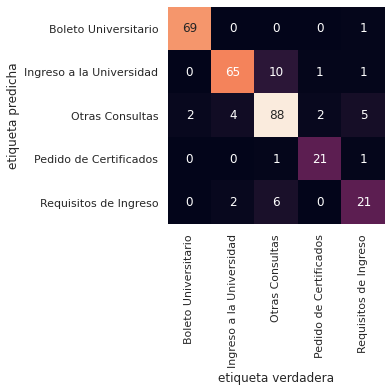

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('etiqueta verdadera')
plt.ylabel('etiqueta predicha');

In [60]:
# Modelo con GridSearchCV

%%time
from sklearn.model_selection import GridSearchCV

modelo_grid = LogisticRegression()

grid_values = {'penalty': ['none', 'l1', 'l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'max_iter': [1000, 5000, 10000, 30000]}

# wrap classifier/regressor in GridSearchCV
clf = GridSearchCV(modelo_grid, 
                   param_grid=grid_values,
                   cv=3,
                   scoring='accuracy',
                   verbose=False)

# fit gridsearch 
clf.fit(x_train ,y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf.best_score_,"with params:", clf.best_params_)        

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and

0.790 (+/-0.028) for {'C': 0.001, 'max_iter': 1000, 'penalty': 'none'}
0.351 (+/-0.011) for {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.001, 'max_iter': 5000, 'penalty': 'none'}
0.351 (+/-0.011) for {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.001, 'max_iter': 10000, 'penalty': 'none'}
0.351 (+/-0.011) for {'C': 0.001, 'max_iter': 10000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.001, 'max_iter': 30000, 'penalty': 'none'}
0.351 (+/-0.011) for {'C': 0.001, 'max_iter': 30000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
0.687 (+/-0.029) for {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.01, 'max_iter': 5000, 'penalty': 'none'}
0.687 (+/-0.029) for {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2'}
0.790 (+/-0.028) for {'C': 0.01, 'max_iter': 10000, 'penalty': 'none'}
0.687 (+/-0.029) for {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2'}
0.790 (+/-0.028) for